In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(tidyr)

# switches with high correlation with:
## stromal content
stromaCorr <- lapply(cancerTypes, function(tumor){
    filename <- paste0("../data/switches/estimate/", tumor, "_ouptut_r_stroma.txt")
    read.delim(filename) %>%
        mutate(., Switch=row.names(.), Tumor=tumor, SwitchCorrelation="Stroma") %>%
        filter(pcorr_linear < 0.05 | pcorr_wilcox < 0.05) %>%
        separate(Switch,into=c("Normal_transcript","Tumor_transcript"), sep="-")
}) %>% do.call("rbind", .)

## immune content
immuneCorr <- lapply(cancerTypes, function(tumor){
    filename <- paste0("../data/switches/estimate/", tumor, "_ouptut_r_immune.txt")
    read.delim(filename) %>%
        mutate(., Switch=row.names(.), Tumor=tumor, SwitchCorrelation="Immune") %>%
        filter(pcorr_linear < 0.05 | pcorr_wilcox < 0.05) %>%
        separate(Switch,into=c("Normal_transcript","Tumor_transcript"), sep="-")
}) %>% do.call("rbind", .)

contaminantSwitches <- rbind(stromaCorr[,c("Normal_transcript","Tumor_transcript","SwitchCorrelation")],
                             immuneCorr[,c("Normal_transcript","Tumor_transcript","SwitchCorrelation")])

# cell-lineage specific genes
cellSpecificGenes <- read_tsv("../data/switches/estimate/geneset_ESTIMATE.txt", col_names = FALSE) %>% 
    t %>%
    as.data.frame %>%
    set_colnames(c("StromalSignature","ImmuneSignature")) %>%
    .[3:nrow(.),]

stromaGenes <- data.frame(Symbol=cellSpecificGenes$StromalSignature, Genetype="Stroma")
immuneGenes <- data.frame(Symbol=cellSpecificGenes$ImmuneSignature, Genetype="Immune")

contaminantGenes <- rbind(stromaGenes,immuneGenes)

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1) 

annotated.switches <- switches %>%
    left_join(contaminantSwitches) %>%
    left_join(contaminantGenes) %>%
    select(Normal_transcript, Tumor_transcript, Genetype,SwitchCorrelation) %>%
    mutate(Genetype = ifelse(is.na(Genetype), "Tumor", as.character(Genetype)),
           SwitchCorrelation = ifelse(is.na(SwitchCorrelation), "Tumor", SwitchCorrelation),
           # cases where the switch and the gene analysis do not agree are "Uncertain"
           Origin = ifelse(Genetype==SwitchCorrelation, SwitchCorrelation, "Uncertain"),
           Origin = ifelse(Origin=="Uncertain" & SwitchCorrelation=="Tumor", Genetype, Origin),
           Origin = ifelse(Origin=="Uncertain" & Genetype=="Tumor", SwitchCorrelation, Origin)) %>%
    group_by(Normal_transcript,Tumor_transcript) %>%
    summarise(Origin=paste0(sort(unique(Origin)), collapse="&")) %>%
    mutate(Origin=ifelse(grepl("&Uncertain",Origin), "Uncertain", Origin)) %>%
    merge(switches)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:reshape2’:

    smiths

Joining by: c("Normal_transcript", "Tumor_transcript")
Joining by: "Symbol"
Warning message:
In left_join_impl(x, y, by$x, by$y): joining factor and character vector, coercing into character vector

In [2]:
tumor <- "brca"
    filename <- paste0("../data/switches/estimate/", tumor, "_ouptut_r_immune.txt")
    read.delim(filename) %>%
        
        mutate(., Switch=row.names(.), Tumor=tumor, SwitchCorrelation="Immune") %>%
filter(pcorr_linear < 0.05 | pcorr_wilcox < 0.05) %>%

        separate(Switch,into=c("Normal_transcript","Tumor_transcript"), sep="-") %>%
head

,p.linear.model,p.wilcox,mean.switch,mean.wt,pcorr_linear,pcorr_wilcox,Normal_transcript,Tumor_transcript,Tumor,SwitchCorrelation
1,0.0001882934,0.0001174951,-155.2321,225.6199,0.01660199,0.0119845,uc003qig.3,uc003qii.2,brca,Immune
2,4.475417e-05,0.0001921507,488.3712,160.1166,0.00514335,0.01819941,uc003tlz.2,uc003tma.2,brca,Immune
3,4.841261e-13,8.470195e-16,-326.439,265.0356,2.139837e-10,3.743826e-13,uc001uip.2,uc001uio.2,brca,Immune
4,4.297319e-21,3.210739e-23,-497.1524,282.2325,2.849122e-18,2.12872e-20,uc003hbg.1,uc003hbe.1,brca,Immune
5,3.436742e-05,2.540585e-05,-277.5541,223.311,0.00455712,0.003743129,uc001xzg.2,uc001xzh.2,brca,Immune
6,0.0002720284,0.0003804549,-712.3861,208.8355,0.01898472,0.02802684,uc011leg.1,uc003xul.2,brca,Immune


# Stoma/immune associated switches

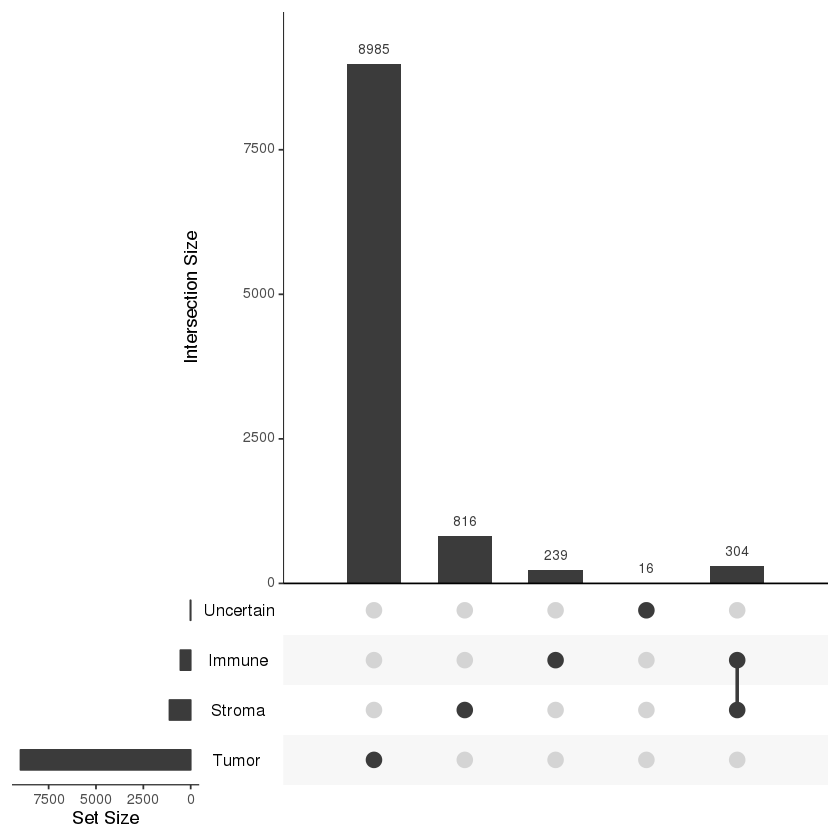

In [3]:
library(UpSetR)

annotated.switches %>%
    .$Origin %>%
    table %>%
    fromExpression(.) %>%
    upset

We cannot link an artifactual origin to most of the switches.

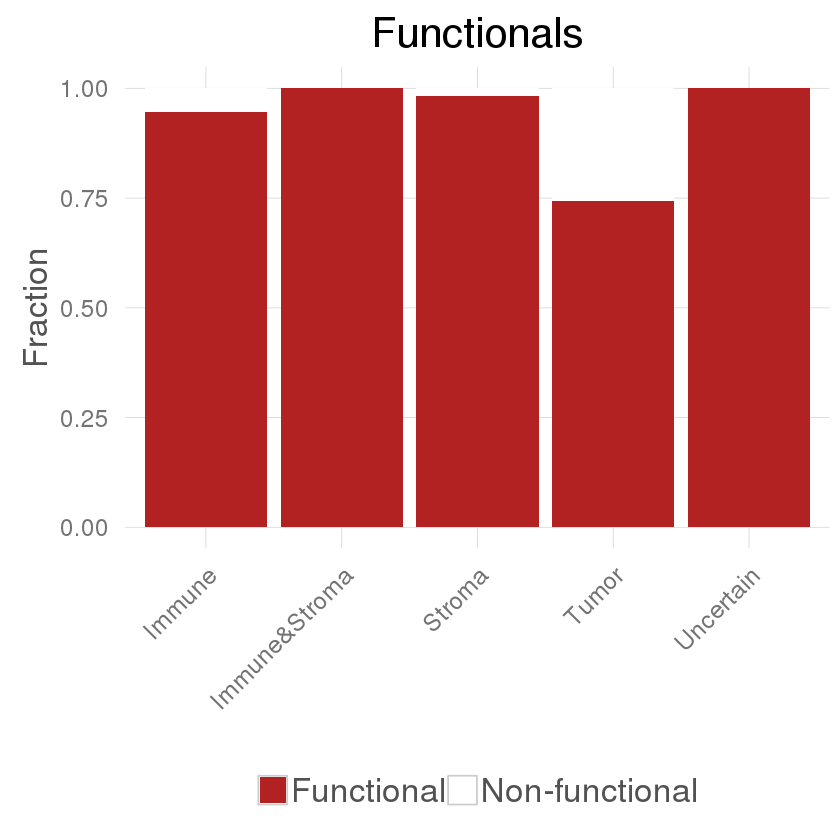

In [4]:
ggplot(annotated.switches, aes(x=Origin, fill=ifelse(IsFunctional==1, "Functional", "Non-functional"))) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction", fill="", title="Functionals") +
    smartas_theme() +
    theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_manual(values = c("Functional"="firebrick", "Non-functional"="white"))

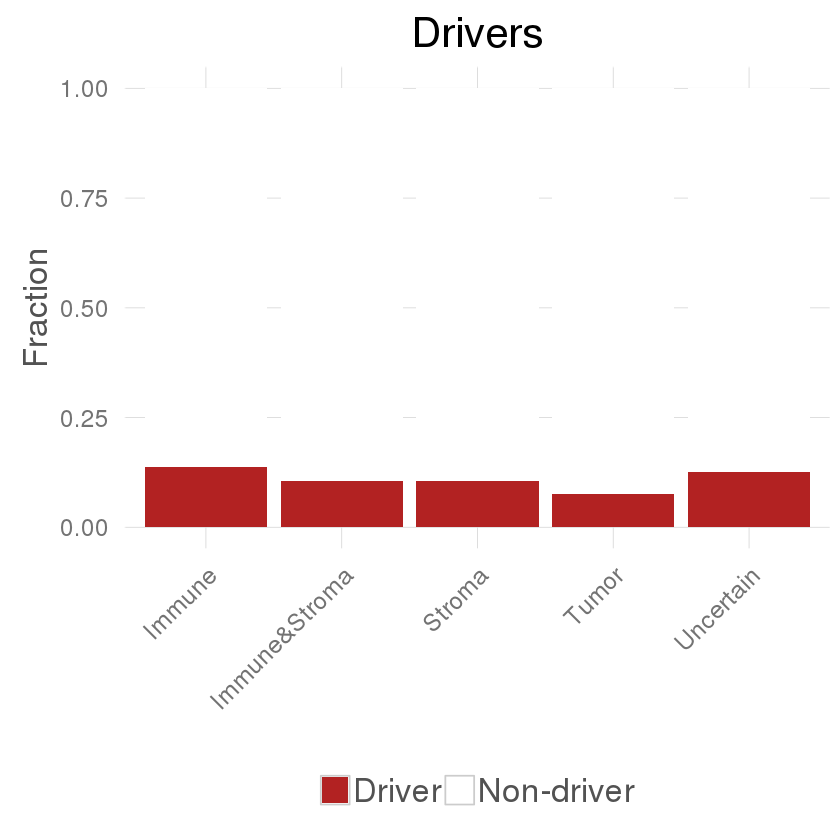

In [5]:
ggplot(annotated.switches, aes(x=Origin, fill=ifelse(Driver==1, "Driver", "Non-driver"))) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction" , fill="", title="Drivers") +
    smartas_theme() +
    theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_manual(values = c("Driver"="firebrick", "Non-driver"="white"))

The proportion of drivers affected are similar across categories, albeit unexpectedly lower in Tumor switches.

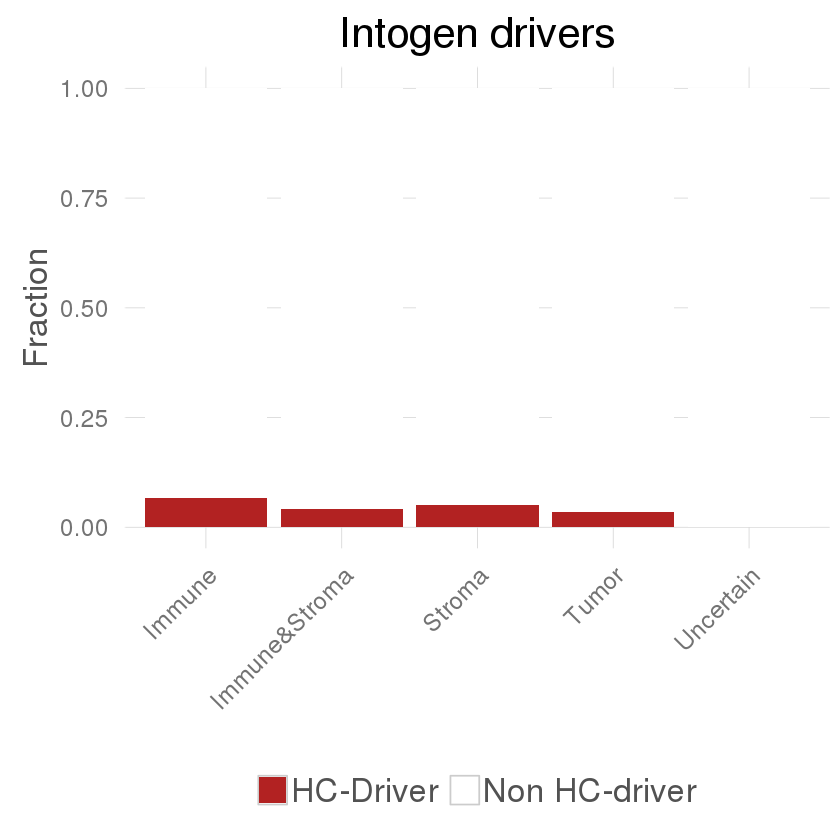

In [6]:
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  set_colnames(c("Symbol","Tumor"))

ggplot(annotated.switches, aes(x=Origin, fill=ifelse(Symbol %in% drivers$Symbol, "HC-Driver", "Non HC-driver"))) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction" , fill="", title="Intogen drivers") +
    smartas_theme() +
    theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_manual(values = c("HC-Driver"="firebrick", "Non HC-driver"="white"))

Still, the proportion of high-confidence drivers is pretty similar across categories.

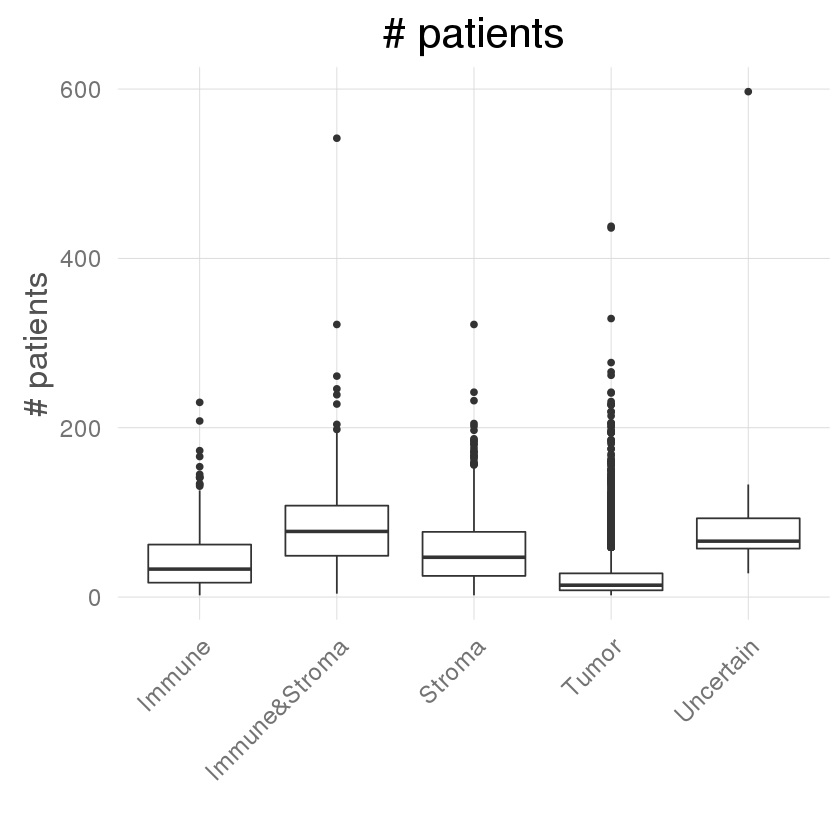

In [7]:
ggplot(annotated.switches, aes(x=Origin, y=PatientNumber)) +
    geom_boxplot() +
    labs(x="", y="# patients", title="# patients") +
    smartas_theme() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

Interestingly, most of the stroma/immune specific genes do not show a correlation with the presence of stroma/immune cells, respectively.

# Intersection with PoTuS

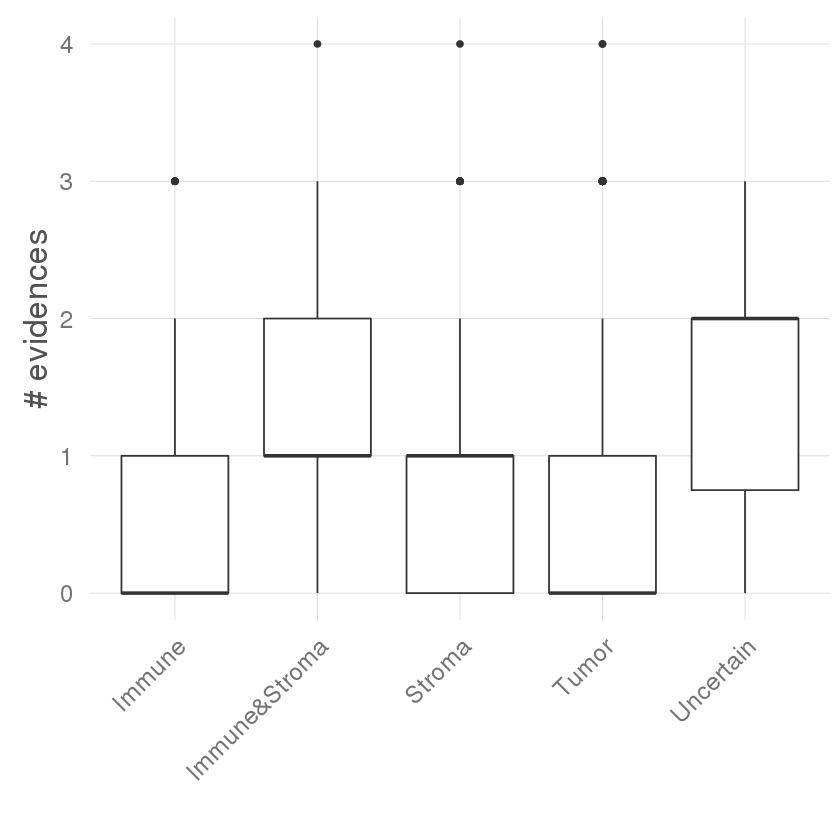

In [8]:
annotated.switches %>%
    filter(IsFunctional==1) %>%
    mutate(ASDriver = Recurrence+DriverME+Affects_mutated_feature+PPI+as.logical(Pannegative)) %>%
    select(ASDriver,Origin) %>% 
    ggplot(aes(x = Origin, y = ASDriver)) +
        geom_boxplot() +
        labs(x="", y="# evidences") +
        smartas_theme() + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

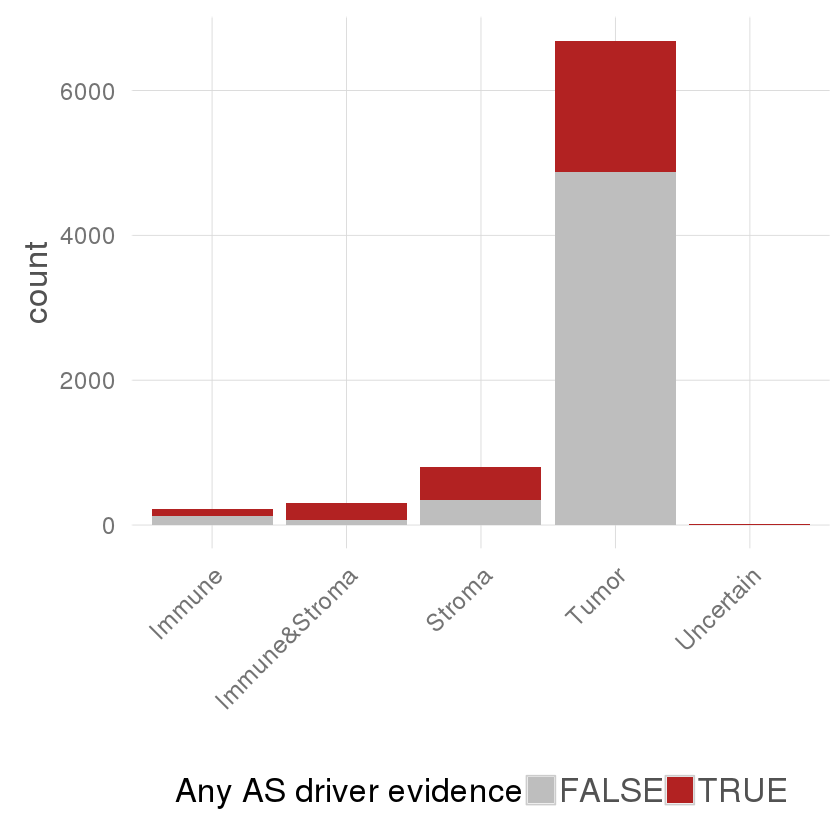

In [9]:
annotated.switches %>%
    filter(IsFunctional==1) %>%
    mutate(ASDriver = Recurrence+DriverME+Affects_mutated_feature+PPI+as.logical(Pannegative)) %>%
    select(ASDriver,Origin) %>% 
    ggplot(aes(x = Origin, fill = as.logical(ASDriver))) +
        geom_bar() +
        smartas_theme() +
        labs(fill="Any AS driver evidence", x="") +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_fill_manual(values = c("TRUE"="firebrick", "FALSE"="grey"))